# CIC-IDS-2017 Classification using BERT


---

**Abstract**

In this notebook, I extend the work of **Οδυσσέας Κουβέλης** (refer to the original [notebook here](https://www.kaggle.com/code/nolovelost/cic-ids-2017-mlps-v-3-3/notebook)) on binary classification using the **CIC-IDS-2017** cybersecurity dataset. While the original work employed **Multilayered Perceptrons (MLPs)** to classify network traffic as benign or malicious, we explore a more advanced approach using **BERT (Bidirectional Encoder Representations from Transformers)**, a transformer-based model that excels at handling sequential data.

My goal is to enhance the performance of Intrusion Detection Systems (IDS) by leveraging BERT's contextual understanding of features to classify network flow samples. In this approach, we preprocess the network traffic data into a format suitable for BERT, fine-tune a pre-trained BERT model, and evaluate its performance on the dataset. We aim to demonstrate how BERT's transformer architecture can improve the accuracy and efficiency of intrusion detection compared to traditional machine learning models.

By adapting BERT for cybersecurity, I contribute to the field by exploring its potential to recognize complex patterns in network traffic data. I evaluate the model's performance using metrics like **accuracy**, **precision**, **recall**, and **F1-score**, and compare it with the results from **MLPs** used in prior work. The insights gained from this study could lead to more robust and accurate IDS implementations in cybersecurity applications.

---


# Data Preparation

## Importing Necessary Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Natural Language Processing Libraries
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader

# Evaluation Metrics
from sklearn.metrics import classification_report, accuracy_score


---

## Data Preprocessing


The **CIC-IDS-2017** dataset can be accessed on [Kaggle](https://www.kaggle.com/) or through the **Canadian Institute for Cybersecurity** website: [CIC-IDS-2017 Dataset](https://www.unb.ca/cic/datasets/ids-2017.html).


---

### Loading the Data

In [2]:
# Load the CIC-IDS-2017 datasets
datasets = {
    'Benign-Monday': '/kaggle/input/cicids2017/Benign-Monday-no-metadata.parquet',
    'Botnet-Friday': '/kaggle/input/cicids2017/Botnet-Friday-no-metadata.parquet',
    'Bruteforce-Tuesday': '/kaggle/input/cicids2017/Bruteforce-Tuesday-no-metadata.parquet',
    'DDoS-Friday': '/kaggle/input/cicids2017/DDoS-Friday-no-metadata.parquet',
    'DoS-Wednesday': '/kaggle/input/cicids2017/DoS-Wednesday-no-metadata.parquet',
    'Infiltration-Thursday': '/kaggle/input/cicids2017/Infiltration-Thursday-no-metadata.parquet',
    'Portscan-Friday': '/kaggle/input/cicids2017/Portscan-Friday-no-metadata.parquet',
    'WebAttacks-Thursday': '/kaggle/input/cicids2017/WebAttacks-Thursday-no-metadata.parquet'
}

# Read the datasets into DataFrames
df_data = {key: pd.read_parquet(path) for key, path in datasets.items()}


In [3]:
# Display the first 5 rows of each DataFrame
for name, df in df_data.items():
    print(f"Head of {name}:")
    # print(df.head(), "\n")


Head of Benign-Monday:
Head of Botnet-Friday:
Head of Bruteforce-Tuesday:
Head of DDoS-Friday:
Head of DoS-Wednesday:
Head of Infiltration-Thursday:
Head of Portscan-Friday:
Head of WebAttacks-Thursday:


In [4]:
# Concatenate all DataFrames into one
df_all = pd.concat(df_data.values(), ignore_index=True)

# Display the first 5 rows of the concatenated DataFrame
# print(df_all.head())


In [5]:
# Find and handle null values

# Get the count of null values in each column
null_counts = df_all.isnull().sum()

# Print the total number of null entries in the dataset
print(f"Total null entries found: {null_counts.sum()}\n")

# Drop rows with any null values
df_all.dropna(inplace=True)  

# Find and handle duplicates

# Get the count of duplicate rows
duplicate_count = df_all.duplicated().sum()

# # Print the number of duplicate entries found
print(f"Total duplicate entries found: {duplicate_count}\n")

# Remove duplicate rows from the dataset
df_all.drop_duplicates(inplace=True) 

# Inform that duplicates have been removed
print("All duplicate entries have been removed.\n")

# Reset the index after dropping rows
df_all.reset_index(drop=True, inplace=True)

# Inspect categorical columns
categorical_columns = df_all.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_columns}\n")

# Display the first 5 rows of the cleaned dataset
df_all.head(20)


Total null entries found: 0

Total duplicate entries found: 82004

All duplicate entries have been removed.

Categorical columns: ['Label']



,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.142860,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
5,6,879,9,4,656,3064,313,0,72.888885,136.153809,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
6,6,1160,9,6,3134,3048,1552,0,348.222229,682.482544,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
7,6,524,7,4,2812,2820,1397,0,401.714294,679.914856,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
8,6,6,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
9,6,1119,9,6,3160,3060,1565,0,351.111115,688.214966,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [6]:
# Inspection of Target Feature

print('Shape of Dataframe: ',df_all.shape,'\n')
print('Inspection of Target Feature - y:\n')
# Target feature counts
print(df_all['Label'].value_counts())

Shape of Dataframe:  (2231806, 78) 

Inspection of Target Feature - y:

Label
Benign                        1895314
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [7]:
# Extract features (X) and target (y)
X = df_all.drop(columns=['Label'])
y = (df_all['Label'] != 'Benign').astype(int)  # Binarize labels: 0 for 'Benign', 1 for Malicious

Class Distribution:
🟦 Benign (0): 1,895,314 samples (84.92%)
🟥 Malicious (1): 336,492 samples (15.08%)



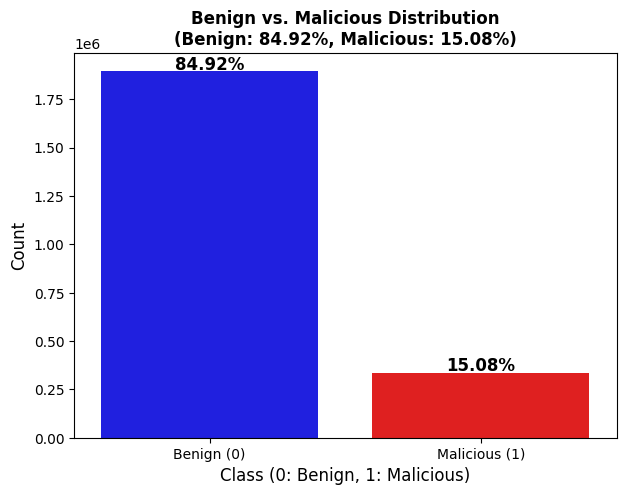

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each class
class_counts = y.value_counts()
total_samples = len(y)

# Calculate percentage of each class
benign_ratio = (class_counts[0] / total_samples) * 100
malicious_ratio = (class_counts[1] / total_samples) * 100

# Print ratios in a clean format
print(f"Class Distribution:\n"
      f"🟦 Benign (0): {class_counts[0]:,} samples ({benign_ratio:.2f}%)\n"
      f"🟥 Malicious (1): {class_counts[1]:,} samples ({malicious_ratio:.2f}%)\n")

# Plot the distribution
plt.figure(figsize=(7, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=["blue", "red"])

# Add labels and title
plt.xlabel("Class (0: Benign, 1: Malicious)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Benign vs. Malicious Distribution\n(Benign: {benign_ratio:.2f}%, Malicious: {malicious_ratio:.2f}%)",
          fontsize=12, fontweight="bold")

# Show percentage on top of bars
for i, val in enumerate(class_counts.values):
    plt.text(i, val + 10000, f"{(val/total_samples)*100:.2f}%", 
             ha='center', fontsize=12, fontweight='bold', color='black')

plt.xticks([0, 1], ["Benign (0)", "Malicious (1)"])
plt.show()


## Class Distribution and Baseline Accuracy

In this dataset, there is a notable **class imbalance**:

- **Class 0** (Majority class): **84.92%** of the samples
- **Class 1** (Minority class): **15.08%** of the samples

A simple model that always predicts the majority class (**Class 0**) would achieve a baseline accuracy of **84.92%**.

Therefore, any machine learning or deep learning model developed for this dataset must perform better than this baseline accuracy by correctly identifying instances from the minority class (**Class 1**) in order to demonstrate meaningful predictive power.


In [9]:
df_all.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


### Splitting the Dataset

In the typical deep learning workflow, it's essential to divide the dataset into separate subsets for **training**, **validation**, and **testing**. This division ensures that the model can be evaluated at each stage and can generalize well to new, unseen data. Here's the breakdown of each subset's purpose:

- **Training Set**: This subset is used to train the model, meaning the model learns the patterns from the data during this phase. Typically, this makes up **60-80%** of the dataset.
  
- **Validation Set**: This set is used during training to evaluate the model’s performance and tune hyperparameters (e.g., learning rate, number of epochs, etc.). It helps ensure that the model is not overfitting to the training data. This usually makes up **10-20%** of the dataset.
  
- **Test Set**: This is used to evaluate the final model after training is complete. The test set is not seen by the model during training, ensuring that it tests the model’s ability to generalize to new, unseen data. It generally comprises **10-20%** of the dataset.


### Key Points:
- **Stratified Split**: `stratify=y` ensures that the class distribution (Class 0 and Class 1) is preserved across the training, validation, and test sets. This is particularly important for imbalanced datasets.
  
- **Test Size**: Here, **20%** of the data is used for testing and validation combined, with half of that (10%) used for validation and the other half (10%) used for testing.

### Why Split the Data?

- **Training Set**: Used to fit the model. The model learns the features and patterns here.
  
- **Validation Set**: Helps monitor the model’s performance during training. If the validation performance starts to degrade while the training performance improves, it could indicate overfitting.
  
- **Test Set**: Used for final evaluation of the model’s performance after training. This ensures that the model is tested on data it hasn't seen before, providing an estimate of how it will perform in a real-world scenario.

By splitting the dataset in this manner, we ensure that the model is trained, tuned, and tested in an unbiased way.

In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and temporary set (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the size of each set
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Validation Set: {X_val.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")

Training Set: 1785444 samples
Validation Set: 223181 samples
Test Set: 223181 samples


### Data Scaling with Robust Scaler

In this notebook, we apply the **Robust Scaler** to scale the features of the **CIC-IDS-2017** dataset. The **Robust Scaler** is particularly useful when dealing with datasets that contain **outliers**, as it scales the data based on the **median** and **interquartile range (IQR)**, making it less sensitive to extreme values compared to methods like **Standardization** or **Min-Max Scaling**.

#### Why use Robust Scaler?
The **CIC-IDS-2017** dataset involves network traffic, which can contain anomalous patterns, such as **attacks** that differ significantly from regular traffic. These extreme values can skew data scaling and affect the performance of machine learning models. The **Robust Scaler** addresses this by focusing on the **median** and **IQR**, which are **robust to outliers**.

#### Formula for Robust Scaling:
The scaling transformation is calculated as follows:

$$
X_{\text{scaled}} = \frac{X - \text{median}(X)}{\text{IQR}(X)}
$$

Where:
- $X$ represents the original value of a feature,
- $\text{median}(X)$ is the median of the feature’s values,
- $ \text{IQR}(X) $ is the interquartile range, which is defined as:

$$
\text{IQR}(X) = Q3(X) - Q1(X)
$$

Where \( Q3(X) \) and \( Q1(X) \) are the 75th and 25th percentiles of the feature's values, respectively.

This transformation centers the data around zero and scales it based on the IQR, reducing the impact of outliers.


In [11]:
# Import necessary libraries
from sklearn.preprocessing import RobustScaler
import pandas as pd

def robust_scale_data(X_train, X_val, X_test):
    """
    Perform Robust Scaling on the features of the training, validation, and test datasets.

    Robust Scaling scales the data using the median and interquartile range (IQR), 
    making it less sensitive to outliers compared to other scaling methods.

    Parameters:
    - X_train (pd.DataFrame): Training dataset with original features.
    - X_val   (pd.DataFrame): Validation dataset with original features.
    - X_test  (pd.DataFrame): Test dataset with original features.

    Returns:
    - Tuple of pd.DataFrame: Scaled training, validation, and test datasets.
    """
    # Initialize the RobustScaler
    scaler = RobustScaler()

    # Fit the scaler on the training data and transform all datasets
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled   = pd.DataFrame(scaler.transform(X_val),       columns=X_val.columns)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test),      columns=X_test.columns)

    return X_train_scaled, X_val_scaled, X_test_scaled

# Apply Robust Scaling to the datasets
X_train_scaled, X_val_scaled, X_test_scaled = robust_scale_data(X_train, X_val, X_test)

# Combine scaled datasets and labels into a list for easy access
scaled_data = [X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test]

### Technical Insight: Scaling Process for Training, Validation, and Test Sets

When scaling data for machine learning models, it is crucial to handle the **training**, **validation**, and **test sets** differently to avoid **data leakage** and ensure the integrity of the model evaluation process.

#### Key Steps in the Scaling Process:
1. **Training Set**:
   - Use the `fit_transform()` method to:
     - **Fit** the scaler (e.g., compute the median and IQR for `RobustScaler`).
     - **Transform** the training data using the computed parameters.

2. **Validation and Test Sets**:
   - Use the `transform()` method to:
     - Apply the **same scaling parameters** (learned from the training set) to the validation and test data.
     - Avoid refitting the scaler on these datasets to prevent data leakage.

#### Why This Matters:
- **Data Leakage Prevention**:
  - Refitting the scaler on the validation or test sets would allow information from these datasets to influence the scaling process, leading to overly optimistic performance metrics.
- **Consistency**:
  - Applying the same scaling parameters ensures that the validation and test sets are transformed in a manner consistent with the training set, maintaining the model's ability to generalize to unseen data.
- **Model Evaluation Integrity**:
  - This practice ensures that the model's performance metrics (e.g., accuracy, F1-score) are reliable and unbiased.

#### Best Practices:
- Always fit the scaler **only on the training data**.
- Use the `transform()` method for validation and test sets to apply the learned scaling parameters.
- Avoid refitting or recomputing scaling parameters on any dataset other than the training set.

By following this approach, you ensure a robust and fair evaluation of your machine learning models while maintaining the integrity of the scaling process.

In [12]:
# Selecting Data Configuration

# Option 1: Use original data (unscaled)
# [X_train, X_val, X_test, y_train, y_val, y_test] = original_data

# Option 2: Use scaled data (preprocessed)
[X_train, X_val, X_test, y_train, y_val, y_test] = scaled_data

# Binary Classification for Intrusion Detection

### Binary Classification for Intrusion Detection

This chapter focuses on the application of **binary classification** for network intrusion detection, specifically within the context of the **CIC-IDS-2017 dataset**. Binary classification, a fundamental machine learning task, involves distinguishing between two distinct classes of data. In cybersecurity, this task is crucial for differentiating between **benign** and **malicious network traffic patterns**. By leveraging binary classification within an **Intrusion Detection System (IDS)**, we can build a robust system capable of flagging suspicious network activity.

---

### Introducing BERT for Binary Classification

For this classification task, the **BERT (Bidirectional Encoder Representations from Transformers)** model is selected. BERT is a state-of-the-art deep learning architecture designed for **natural language processing (NLP)** tasks but has shown remarkable success when adapted to **tabular data** and other structured datasets like CIC-IDS-2017. BERT's architecture is based on the **Transformer** family of models, which are renowned for their ability to capture complex relationships in high-dimensional data using the **self-attention mechanism**. BERT was introduced in 2018 by Google researchers in the paper:

**BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding**

BERT's key innovation lies in its **bidirectional context understanding**, which allows it to consider both past and future context when processing input data. This makes it particularly effective for tasks requiring a deep understanding of relationships within the data.

---

### Self-Attention Mechanism

At the core of BERT lies the **self-attention mechanism**, a powerful tool for capturing relationships within high-dimensional data. This mechanism allows BERT to dynamically weigh the importance of different features during training, enabling it to focus on the most relevant information for making predictions. Mathematically, self-attention computes a weighted sum of the input features, where the weights are determined through a **softmax function** applied to the dot product of query, key, and value vectors:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q \cdot K^T}{\sqrt{d_k}}\right) \cdot V
$$

Here:
- $ Q $, $ K $, and $ V $ represent the **query**, **key**, and **value matrices**, respectively.
- $ d_k $ denotes the dimensionality of the key vectors.

This mechanism allows BERT to adaptively attend to different parts of the input space, effectively capturing complex patterns and dependencies within the data.

---

### BERT: Encoder-Only Architecture

BERT utilizes an **encoder-only architecture**, meaning it focuses solely on extracting informative features from the data and does not require a separate decoder for generating outputs. The encoder in BERT consists of multiple layers of **Transformer blocks**, each comprising:
1. **Multi-Head Self-Attention**: Captures relationships between different parts of the input.
2. **Feed-Forward Neural Networks**: Transforms the attended features into a more useful representation.
3. **Layer Normalization and Residual Connections**: Stabilizes training and improves gradient flow.

The encoder progressively learns more advanced representations of the input data. Initially, the raw features are transformed using techniques like **embedding** and **positional encoding**. Then, BERT's multi-head self-attention mechanism identifies the most relevant features for each data point, allowing it to learn a compressed representation of the data that encapsulates the most critical information for classification.

---

### Adapting BERT for Tabular Data

While BERT was originally designed for NLP tasks, it can be adapted for **tabular data** like the CIC-IDS-2017 dataset by:
1. **Feature Embedding**: Converting numerical and categorical features into dense vector representations.
2. **Positional Encoding**: Adding positional information to the feature embeddings to preserve the order of features.
3. **Fine-Tuning**: Pre-training BERT on a related task (e.g., anomaly detection) and fine-tuning it on the binary classification task.

This adaptation allows BERT to leverage its powerful self-attention mechanism for **intrusion detection**, making it a strong candidate for this task.

---

### Visualization of BERT's Internal Architecture

Below is a simplified diagram of BERT's encoder architecture:

Input Features → Embedding Layer → Positional Encoding → Transformer Blocks → Output 

### Representation

Each **Transformer Block** consists of:
- **Multi-Head Self-Attention**
- **Feed-Forward Network**
- **Layer Normalization**
- **Residual Connections**

---

### Why Use BERT for Intrusion Detection?

1. **Bidirectional Context Understanding**:
   - BERT's ability to consider both past and future context makes it highly effective for capturing complex relationships in network traffic data.

2. **Self-Attention Mechanism**:
   - The self-attention mechanism allows BERT to focus on the most relevant features, improving its ability to detect subtle patterns indicative of malicious activity.

3. **Transfer Learning**:
   - BERT's pre-trained weights can be fine-tuned on the CIC-IDS-2017 dataset, reducing the need for large amounts of labeled data.

4. **Scalability**:
   - BERT can handle high-dimensional data efficiently, making it suitable for large-scale intrusion detection systems.

---

### Example Workflow

1. **Preprocessing**:
   - Convert the CIC-IDS-2017 dataset into a format suitable for BERT (e.g., tokenized feature vectors).
   - Apply feature scaling or normalization if necessary.

2. **Model Training**:
   - Fine-tune a pre-trained BERT model on the binary classification task (benign vs. malicious).
   - Use techniques like **learning rate scheduling** and **early stopping** to optimize training.

3. **Evaluation**:
   - Evaluate the model on the test set using metrics like **accuracy**, **precision**, **recall**, and **F1-score**.

4. **Deployment**:
   - Deploy the trained BERT model in an IDS to flag suspicious network activity in real-time.

---

### Key Considerations

- **Computational Resources**: BERT is computationally intensive, so ensure access to GPUs or TPUs for training.
- **Data Preprocessing**: Properly preprocess the tabular data to make it compatible with BERT.
- **Interpretability**: While BERT is powerful, it can be less interpretable than traditional models. Consider using techniques like **SHAP** or **LIME** to explain predictions.

---

By leveraging BERT for binary classification in intrusion detection, we can build a highly accurate and robust system capable of identifying malicious network activity with state-of-the-art performance.
